**Task 2**

In [207]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

Check Cuda Availability

In [189]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Mount google drive

In [190]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define data path

In [191]:
class_priority_path = '/content/drive/My Drive/data/Priority'
class_stop_path = '/content/drive/My Drive/data/Stop'

In [192]:
priority_images = [image for image in os.listdir(class_priority_path) if image.endswith('.jpg')]
stop_images = [image for image in os.listdir(class_stop_path) if image.endswith('.jpg')]
labeled_stop_images_full_path = [(os.path.join(class_stop_path, image), 0) for image in stop_images]
labeled_priority_images_full_path = [(os.path.join(class_priority_path, image), 1) for image in priority_images]
data = labeled_priority_images_full_path + labeled_stop_images_full_path

Load Data to x and y (features and label)

In [193]:
X_array = []
y_array = []

for item in data:
  x_image = cv2.imread(item[0])
  x_image = cv2.resize(x_image, (224, 224))
  X_array.append(x_image)
  y_image = item[1]
  y_array.append(y_image)

X_array = np.array(X_array)
y_array = np.array(y_array)

Data Augmentation

In [194]:
def data_augmentation(image):

  if np.random.rand(1) > 0.5:
    image = cv2.flip(image, 1)

  image = cv2.resize(image, (224, 224))

  return image

In [195]:
X = np.array([data_augmentation(img) for img in X_array])
y = y_array

Convert to Tensor

In [196]:
X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
y = torch.tensor(y, dtype=torch.long)

Train-Test Split

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=122)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Load ResNet18

In [198]:
baseModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
baseModel.fc = nn.Linear(512, 512)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Create Model

In [199]:
hidden_units = 128
output_units = 2
activation_function = nn.Sigmoid()

In [200]:
headModel = nn.AdaptiveAvgPool2d((1,1))
hidden_layer = nn.Linear(512, hidden_units)
dropout_layer = nn.Dropout(p=0.5)
output_layer = nn.Linear(hidden_units, output_units)
model_resnet18_classification = nn.Sequential(baseModel, hidden_layer, activation_function, output_layer)

Train Data

In [201]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,train_size=0.8, test_size=0.2, random_state=42)

epochs = 50
batch_size = 16
loss_function = nn.CrossEntropyLoss()
num_batches_train = (len(X_train) + batch_size - 1) // batch_size
num_batches_val = (len(X_val) + batch_size - 1) // batch_size

optimizer = optim.Adam(model_resnet18_classification.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

for epoch in range(epochs):

  model_resnet18_classification.train().to(device)
  train_loss = 0

  for i in range(num_batches_train):
    batch_inputs = X_train[i * batch_size:(i + 1) * batch_size]
    batch_labels = y_train[i * batch_size:(i + 1) * batch_size]

    optimizer.zero_grad()
    outputs = model_resnet18_classification(batch_inputs)
    loss = loss_function(outputs, batch_labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  epoch_loss = train_loss / num_batches_train

  model_resnet18_classification.eval().to(device)
  val_loss = 0

  with torch.no_grad():
    for j in range(num_batches_val):
      batch_inputs = X_val[j * batch_size:(j + 1) * batch_size]
      batch_labels = y_val[j * batch_size:(j + 1) * batch_size]

      outputs = model_resnet18_classification(batch_inputs)
      loss = loss_function(outputs, batch_labels)
      val_loss += loss.item()

    val_loss /= num_batches_val
    scheduler.step(val_loss)

  epoch_train_loss = train_loss / num_batches_train

  print(f'epoch {epoch+1} Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch 1 Train Loss: 5.976744, Val Loss: 1.910841
epoch 2 Train Loss: 1.578781, Val Loss: 0.026391
epoch 3 Train Loss: 0.646245, Val Loss: 0.133658
epoch 4 Train Loss: 3.306656, Val Loss: 0.586929
epoch 5 Train Loss: 0.900740, Val Loss: 1.576293
epoch 6 Train Loss: 0.703947, Val Loss: 0.718163
epoch 7 Train Loss: 0.213284, Val Loss: 0.017050
epoch 8 Train Loss: 0.363561, Val Loss: 0.012306
epoch 9 Train Loss: 0.488369, Val Loss: 0.047004
epoch 10 Train Loss: 0.123801, Val Loss: 0.007894
epoch 11 Train Loss: 0.071547, Val Loss: 0.003965
epoch 12 Train Loss: 0.053476, Val Loss: 0.003146
epoch 13 Train Loss: 0.046632, Val Loss: 0.002739
epoch 14 Train Loss: 0.041490, Val Loss: 0.002446
epoch 15 Train Loss: 0.037291, Val Loss: 0.002207
epoch 16 Train Loss: 0.033772, Val Loss: 0.002006
epoch 17 Train Loss: 0.030777, Val Loss: 0.001834
epoch 18 Train Loss: 0.028200, Val Loss: 0.001684
epoch 19 Train Loss: 0.025961, Val Loss: 0.001554
epoch 20 Train Loss: 0.024001, Val Loss: 0.001439
epoch 21 

Save Model

In [202]:
torch.save(model_resnet18_classification.state_dict(), 'model_resnet18_classification.pth')

Load Model

In [203]:
baseModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
baseModel.fc = torch.nn.Linear(512, 512)
headModel = torch.nn.AdaptiveAvgPool2d((1,1))
hidden_layer = torch.nn.Linear(512, 128)
dropout_layer = torch.nn.Dropout(p=0.5)
output_layer = torch.nn.Linear(128, 2)
model_resnet18_classification = torch.nn.Sequential(baseModel, hidden_layer, torch.nn.Sigmoid(), output_layer)
model_resnet18_classification = model_resnet18_classification.to(device).eval()
model_resnet18_classification.load_state_dict(torch.load('model_resnet18_classification.pth'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

Model Evaluation

In [204]:
model_resnet18_classification.eval().to(device)

num_batches_test = (len(X_test) + batch_size - 1) // batch_size
actuals = []
predictions = []

with torch.no_grad():
  for i in range(num_batches_test):
    batch_inputs_test = X_test[i * batch_size:(i + 1) * batch_size]
    batch_labels_test = y_test[i * batch_size:(i + 1) * batch_size]

    outputs = model_resnet18_classification(batch_inputs_test)
    _, predicted_labels = torch.max(outputs, 1)
    actuals.append(batch_labels_test.cpu().numpy())
    predictions.append(predicted_labels.cpu().numpy())

actuals = np.concatenate(actuals, axis=0)
predictions = np.concatenate(predictions, axis=0)

accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions, average='weighted')
recall = recall_score(actuals, predictions, average='weighted')
f1 = f1_score(actuals, predictions, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Test on Input Image

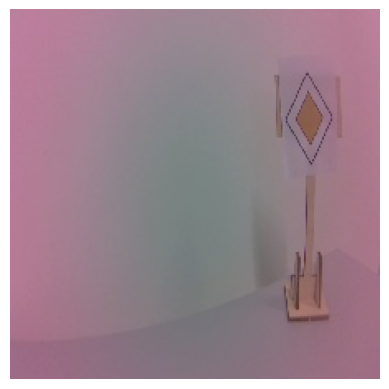


  class_1: Priority


In [221]:
image_path = '/content/Test.jpg'

class_names = ['class_0: Stop', 'class_1: Priority']

image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
image = image.unsqueeze(0)
image /= 255.0

model_resnet18_classification.eval().to(device)
with torch.no_grad():
    outputs = model_resnet18_classification(image.to(device))
    _, predicted_label = torch.max(outputs, 1)

class_index = predicted_label.item()
class_name = class_names[class_index]

plt.imshow(image.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

print("\n ", class_name)